# Reinforcement Learning - CartPole
## Aufgabe Nr. 3
### b): Entwicklung des RL-Agenten

## 1.0 Installierung aller Pakete aus dem requirements.txt

In [1]:
# Install all packages from requirements.txt
!pip install -r requirements.txt

## 1.1 Imports

In [2]:
import math
from typing import Optional, Union
import numpy as np
import gym
from gym import logger, spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled
from gym.utils import seeding
import matplotlib.pyplot as plt

## 1.2 CartPole Umgebung aus dem Github
### Dem Github Code wurde noch eine weitere Box hinzugefügt, so dass das Balancieren ein bisschen erschwert soll
#### Der einfache CartPole Code ist von von https://github.com/openai/gym/commits?author=younik
#### Dieser Code wurde erweitert

In [3]:
class CartPoleBoxEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 50,
        }

    def __init__(self, render_mode: Optional[str] = None):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.massbox = 0.5
        self.total_mass = self.masscart + self.masspole + self.massbox
        self.length = 0.5  # Half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = "euler"

        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        high = np.array(
            [
                self.x_threshold * 2,
                np.finfo(np.float32).max,
                self.theta_threshold_radians * 2,
                np.finfo(np.float32).max,
                ],
            dtype=np.float32,
            )

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state = None

        self.steps_beyond_terminated = None

    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # Dynamics equations incorporating the balancing box on top of the pole
        temp = (
            force + self.polemass_length * theta_dot**2 * sintheta
            ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - (self.masspole + self.massbox) * costheta**2 / self.total_mass)
            )
        xacc = temp - (self.polemass_length + self.massbox * self.length) * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == "euler":
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
            )

        if not terminated:
            reward = 1.0
        elif self.steps_beyond_terminated is None:
            # Pole just fell!
            self.steps_beyond_terminated = 0
            reward = 1.0
        else:
            if self.steps_beyond_terminated == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned terminated = True. You "
                    "should always call 'reset()' once you receive 'terminated = "
                    "True' -- any further steps are undefined behavior."
                    )
            self.steps_beyond_terminated += 1
            reward = 0.0

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
        ):
        super().reset(seed=seed)
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.05, 0.05  # default low
            )  # default high
        self.state = self.np_random.uniform(low=low, high=high, size=(4,))
        self.steps_beyond_terminated = None

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
                )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install pygame`"
                )

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                    )
            else:  # mode == "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.x_threshold * 2
        scale = self.screen_width / world_width
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0
        box_size = 30.0

        if self.state is None:
            return None

        x = self.state

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
        axleoffset = cartheight / 4.0
        cartx = x[0] * scale + self.screen_width / 2.0  # MIDDLE OF CART
        carty = 100  # TOP OF CART
        cart_coords = [(l, b), (l, t), (r, t), (r, b)]
        cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
        gfxdraw.aapolygon(self.surf, cart_coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, cart_coords, (0, 0, 0))

        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
            )

        pole_coords = []
        for coord in [(l, b), (l, t), (r, t), (r, b)]:
            coord = pygame.math.Vector2(coord).rotate_rad(-x[2])
            coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
            pole_coords.append(coord)
        gfxdraw.aapolygon(self.surf, pole_coords, (202, 152, 101))
        gfxdraw.filled_polygon(self.surf, pole_coords, (202, 152, 101))

        gfxdraw.aacircle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
            )
        gfxdraw.filled_circle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
            )

        # Add a box on top of the pole
        box_x = cartx + polelen * math.sin(x[2])
        box_y = carty - polelen * math.cos(x[2]) - box_size / 2
        box_coords = [
            (box_x - box_size / 2, box_y - box_size / 2),
            (box_x + box_size / 2, box_y - box_size / 2),
            (box_x + box_size / 2, box_y + box_size / 2),
            (box_x - box_size / 2, box_y + box_size / 2),
            ]
    
        gfxdraw.aapolygon(self.surf, box_coords, (255, 0, 0))
        gfxdraw.filled_polygon(self.surf, box_coords, (255, 0, 0))

        gfxdraw.hline(self.surf, 0, self.screen_width, carty, (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
                )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

# Registering the environment
gym.envs.registration.register(
    id='CartPoleBox-v0',
    entry_point=CartPoleBoxEnv,
    max_episode_steps=200,
    )

# Example usage
if __name__ == '__main__':
    env = gym.make('CartPoleBox-v0', render_mode="human")
    obs, info = env.reset()
    for _ in range(200):
        action = env.action_space.sample()  # Random action for demonstration
        obs, reward, done, truncated, info = env.step(action)
        if done:
            obs, info = env.reset()
    env.close()

C:\Users\esmag\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## 1.3 Implementierung des Q-Learnings
### c): Bewertung und Visualisierung
#### Dieser Code wurde teilweise mit ChatGPT generiert

C:\Users\esmag\anaconda3\Lib\site-packages\gym\envs\registration.py:498: UserWarning: WARN: Overriding environment CartPoleBox-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


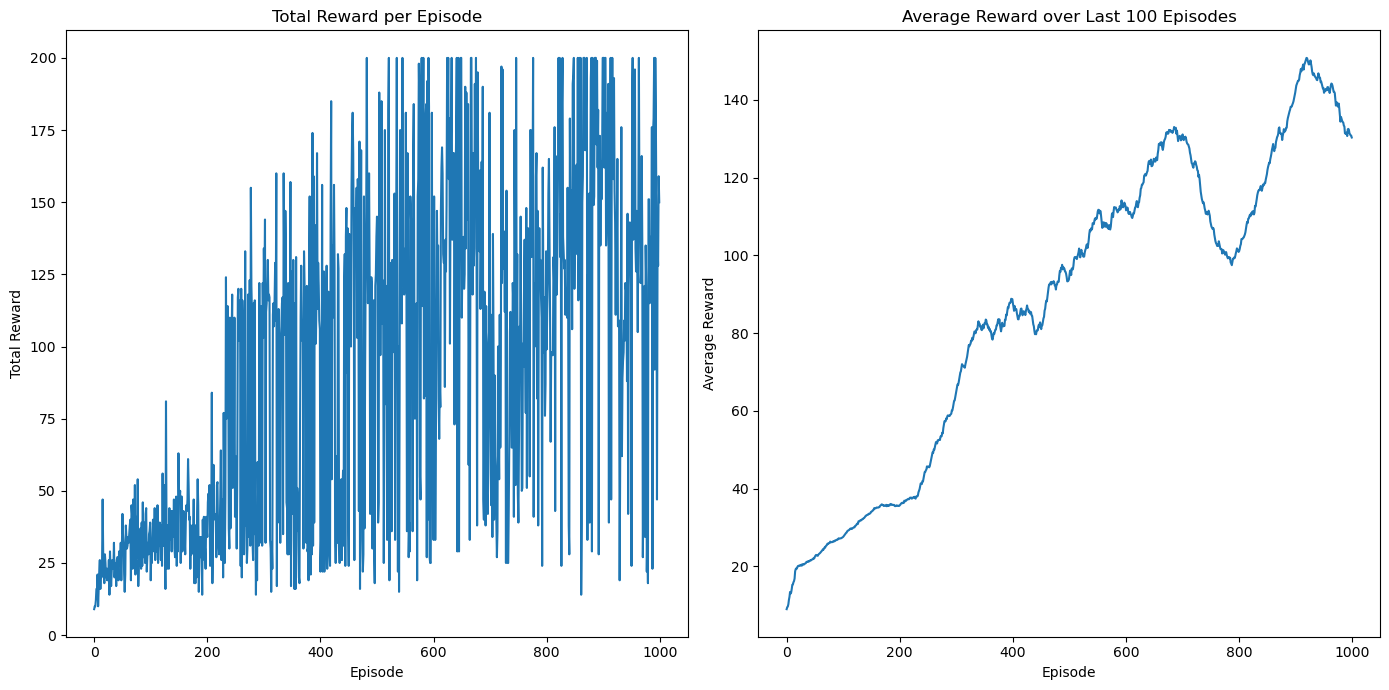

In [4]:
# Registering the environment
gym.envs.registration.register(
    id='CartPoleBox-v0',
    entry_point=CartPoleBoxEnv,
    max_episode_steps=200,
    )

# Q-learning implementation
# Create the CartPoleBox environment
env = gym.make('CartPoleBox-v0')

# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 0.1  # Exploration-exploitation tradeoff
num_episodes = 1000
max_steps = 200

# Define the number of discrete buckets for each state dimension
buckets = (6, 12, 6, 12)  # Cart position, Cart velocity, Pole angle, Pole velocity

# Initialize Q-table
Q_table = np.zeros(buckets + (env.action_space.n,))

# Discretize the state
def discretize_state(state):
    upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
    lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
    ratios = [(state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
    new_state = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(state))]
    new_state = [min(buckets[i] - 1, max(0, new_state[i])) for i in range(len(state))]
    return tuple(new_state)

# Training the agent
reward_list = []
average_reward_list = []
for episode in range(num_episodes):
    state = env.reset()[0]
    discrete_state = discretize_state(state)
    total_reward = 0
    for step in range(max_steps):
        if np.random.random() < epsilon:
            action = np.random.randint(0, env.action_space.n)
        else:
            action = np.argmax(Q_table[discrete_state])

        next_state, reward, done, truncated, _ = env.step(action)
        next_discrete_state = discretize_state(next_state)

        if done and step < max_steps - 1:
            Q_table[discrete_state + (action,)] = -100
        else:
            max_future_q = np.max(Q_table[next_discrete_state])
            current_q = Q_table[discrete_state + (action,)]
            new_q = (1 - alpha) * current_q + alpha * (reward + gamma * max_future_q)
            Q_table[discrete_state + (action,)] = new_q

        discrete_state = next_discrete_state
        total_reward += reward

        if done:
            break

    reward_list.append(total_reward)
    average_reward = np.mean(reward_list[-100:])  # Calculate the average reward over the last 100 episodes
    average_reward_list.append(average_reward)

# Save the model
np.save("q_table.npy", Q_table)

# Plot the total reward and the average reward over episodes
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(reward_list)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')

plt.subplot(1, 2, 2)
plt.plot(average_reward_list)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward over Last 100 Episodes')

plt.tight_layout()
plt.show()

## 1.4 Neuer Durchlauf mit Q-Learning
#### Dieser Code wurde teilweise mit ChatGPT generiert

In [5]:
# env = gym.make('CartPoleBox-v0')

# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration-exploitation tradeoff, start with high exploration
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 1000
max_steps = 200

# Define the number of discrete buckets for each state dimension
buckets = (1, 1, 6, 3)  # Cart position, Cart velocity, Pole angle, Pole velocity

# Initialize Q-table
Q_table = np.zeros(buckets + (env.action_space.n,))

# Discretize the state
def discretize_state(state):
    upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
    lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
    ratios = [(state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
    new_state = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(state))]
    new_state = [min(buckets[i] - 1, max(0, new_state[i])) for i in range(len(state))]
    return tuple(new_state)

# Training the agent
reward_list = []
save_intervals = [100, 500, 1000]  # Save Q-table at these intervals
Q_tables = []

for episode in range(num_episodes):
    state = env.reset()[0]
    discrete_state = discretize_state(state)
    total_reward = 0
    for step in range(max_steps):
        if np.random.random() < epsilon:
            action = np.random.randint(0, env.action_space.n)
        else:
            action = np.argmax(Q_table[discrete_state])

        next_state, reward, done, truncated, _ = env.step(action)
        next_discrete_state = discretize_state(next_state)

        if done and step < max_steps - 1:
            Q_table[discrete_state + (action,)] = -100
        else:
            max_future_q = np.max(Q_table[next_discrete_state])
            current_q = Q_table[discrete_state + (action,)]
            new_q = (1 - alpha) * current_q + alpha * (reward + gamma * max_future_q)
            Q_table[discrete_state + (action,)] = new_q

        discrete_state = next_discrete_state
        total_reward += reward

        if done:
            break

    reward_list.append(total_reward)

    if episode + 1 in save_intervals:
        Q_tables.append(np.copy(Q_table))

    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# Function to visualize performance
def visualize_performance(Q_table, num_episodes=5):
    env = gym.make('CartPoleBox-v0', render_mode="human")
    for episode in range(num_episodes):
        state = env.reset()[0]
        discrete_state = discretize_state(state)
        done = False
        while not done:
            action = np.argmax(Q_table[discrete_state])
            next_state, reward, done, truncated, _ = env.step(action)
            discrete_state = discretize_state(next_state)
    env.close()

# Visualize performance at different stages
# Initially, the performance was very poor, and these segments ran through quickly.
# As the agent's performance improved, the duration of the visualization increased, eventually leading to the termination of the visualization.
print("Performance after 100 episodes:")
visualize_performance(Q_tables[0])

print("Performance after 500 episodes:")
visualize_performance(Q_tables[1])

print("Performance after 1000 episodes:")
visualize_performance(Q_tables[2])


Performance after 100 episodes:
Performance after 500 episodes:
Performance after 1000 episodes:
